# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import sys

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Sampling the data 
final = final.sample(n=100000)

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 100000/100000 [00:39<00:00, 2501.43it/s]


In [24]:
preprocessed_reviews[1500]

'wish thought purchase little longer takes large space work sifting clumps dumped large container trash bag litter one large container another sifter reinserted clear enough look picture yet not really think hard without spillage pretty messy seems like major operation currently using sifting liners inserted contraption ignoring sifting capabilities altogether find much easier keep box clean not really use liner three large pieces need cleaned'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
## Similartly you can do preprocessing for review summary also.

In [26]:
## Similarly you can do preprocessing for review summary also.

# Combining all the above stundents 
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for summary in tqdm(final['Summary'].values):
    summary = re.sub(r"http\S+", "", summary)
    summary = BeautifulSoup(summary, 'lxml').get_text()
    summary = decontracted(summary)
    summary = re.sub("\S*\d\S*", "", summary).strip()
    summary = re.sub('[^A-Za-z]+', ' ', summary)
    # https://gist.github.com/sebleier/554280
    summary = ' '.join(e.lower() for e in summary.split() if e.lower() not in stopwords)
    
    preprocessed_summary.append(summary.strip())


100%|██████████| 100000/100000 [00:26<00:00, 3776.53it/s]


In [27]:
final['CleanedText'] = preprocessed_reviews #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText'] = final['CleanedText'].astype('str')

final['CleanedSummary'] = preprocessed_summary #adding a column of CleanedSummary which displays the data after pre-processing of the Summary 
final['CleanedSummary'] = final['CleanedSummary'].astype('str')

final['Text_Summary'] = final['CleanedSummary'] + final['CleanedText']

# # store final table into an SQlLite table for future.
# conn = sqlite3.connect('final.sqlite')
# c=conn.cursor()
# conn.text_factory = str
# final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
#              index=True, index_label=None, chunksize=None, dtype=None)
# conn.close()

# [4] Featurization

## [4.1] BAG OF WORDS

In [28]:
# #BoW
# count_vect = CountVectorizer() #in scikit-learn
# count_vect.fit(preprocessed_reviews)
# print("some feature names ", count_vect.get_feature_names()[:10])
# print('='*50)

# final_counts = count_vect.transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_counts))
# print("the shape of out text BOW vectorizer ",final_counts.get_shape())
# print("the number of unique words ", final_counts.get_shape()[1])

## [4.2] Bi-Grams and n-Grams.

In [29]:
# #bi-gram, tri-gram and n-gram

# #removing stop words like "not" should be avoided before building n-grams
# # count_vect = CountVectorizer(ngram_range=(1,2))
# # please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# # you can choose these numebrs min_df=10, max_features=5000, of your choice
# count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
# final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_bigram_counts))
# print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
# print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [30]:
# tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
# tf_idf_vect.fit(preprocessed_reviews)
# print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
# print('='*50)

# final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_tf_idf))
# print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
# print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

## [4.4] Word2Vec

In [31]:
# # Train your own Word2Vec model using your own text corpus
# i=0
# list_of_sentance=[]
# for sentance in preprocessed_reviews:
#     list_of_sentance.append(sentance.split())

In [32]:
# # Using Google News Word2Vectors

# # in this project we are using a pretrained model by google
# # its 3.3G file, once you load this into your memory 
# # it occupies ~9Gb, so please do this step only if you have >12G of ram
# # we will provide a pickle file wich contains a dict , 
# # and it contains all our courpus words as keys and  model[word] as values
# # To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# # from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# # it's 1.9GB in size.


# # http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# # you can comment this whole cell
# # or change these varible according to your need

# is_your_ram_gt_16g=False
# want_to_use_google_w2v = False
# want_to_train_w2v = True

# if want_to_train_w2v:
#     # min_count = 5 considers only words that occured atleast 5 times
#     w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
#     print(w2v_model.wv.most_similar('great'))
#     print('='*50)
#     print(w2v_model.wv.most_similar('worst'))
    
# elif want_to_use_google_w2v and is_your_ram_gt_16g:
#     if os.path.isfile('GoogleNews-vectors-negative300.bin'):
#         w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
#         print(w2v_model.wv.most_similar('great'))
#         print(w2v_model.wv.most_similar('worst'))
#     else:
#         print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

In [33]:
# w2v_words = list(w2v_model.wv.vocab)
# print("number of words that occured minimum 5 times ",len(w2v_words))
# print("sample words ", w2v_words[0:50])

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [34]:
# # average Word2Vec
# # compute average word2vec for each review.
# sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# for sent in tqdm(list_of_sentance): # for each review/sentence
#     sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
#     cnt_words =0; # num of words with a valid vector in the sentence/review
#     for word in sent: # for each word in a review/sentence
#         if word in w2v_words:
#             vec = w2v_model.wv[word]
#             sent_vec += vec
#             cnt_words += 1
#     if cnt_words != 0:
#         sent_vec /= cnt_words
#     sent_vectors.append(sent_vec)
# print(len(sent_vectors))
# print(len(sent_vectors[0]))

#### [4.4.1.2] TFIDF weighted W2v

In [35]:
# # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# model = TfidfVectorizer()
# tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [36]:
# # TF-IDF weighted Word2Vec
# tfidf_feat = model.get_feature_names() # tfidf words/col-names
# # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

# tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
# row=0;
# for sent in tqdm(list_of_sentance): # for each review/sentence 
#     sent_vec = np.zeros(50) # as word vectors are of zero length
#     weight_sum =0; # num of words with a valid vector in the sentence/review
#     for word in sent: # for each word in a review/sentence
#         if word in w2v_words and word in tfidf_feat:
#             vec = w2v_model.wv[word]
# #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
#             # to reduce the computation we are 
#             # dictionary[word] = idf value of word in whole courpus
#             # sent.count(word) = tf valeus of word in this review
#             tf_idf = dictionary[word]*(sent.count(word)/len(sent))
#             sent_vec += (vec * tf_idf)
#             weight_sum += tf_idf
#     if weight_sum != 0:
#         sent_vec /= weight_sum
#     tfidf_sent_vectors.append(sent_vec)
#     row += 1

# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

In [37]:
# Please write all the code with proper documentation

In [38]:
# Source: https://docs.python.org/3/library/pickle.html

# Saving data to pickle file
def topicklefile(obj, file_name):
    pickle.dump(obj,open(file_name+'.pkl', 'wb'))

In [39]:
# Data from pickle file
def frompicklefile(file_name):
    data = pickle.load(open(file_name+'.pkl', 'rb'))
    return data

In [40]:
# Sort 'Time' column
final = final.sort_values(by='Time', ascending=True)

In [41]:
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

# Train Test split for train and test data
def data_split(X,y):
    # split the data set into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)
    topicklefile(X_train, 'X_train')
    topicklefile(X_test, 'X_test')
    topicklefile(y_train, 'y_train')
    topicklefile(y_test, 'y_test')

In [42]:
def apply_avgw2v_train_test(X_train, X_test):
    
    # Training own Word2Vec model using your own text corpus
    list_of_sent_train = []
    for sent in X_train:#final['Text_Summary'].values:
        list_of_sent_train.append(sent.split())
    list_of_sent_test = []
    for sent in X_test:#final['Text_Summary'].values:
        list_of_sent_test.append(sent.split())

    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sent_train,min_count=5,size=50, workers=8)

    w2v_words = list(w2v_model.wv.vocab)
#     print("number of words that occured minimum 5 times ",len(w2v_words))
#     print("sample words ", w2v_words[0:50])

    # compute average word2vec for each review for train data 
    avgw2v_train = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sent_train): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        avgw2v_train.append(sent_vec)
#     print(len(avgw2v_train))
#     print(len(avgw2v_train[0]))

    # compute average word2vec for each review for test data 
    avgw2v_test = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sent_test): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        avgw2v_test.append(sent_vec)
#     print(len(avgw2v_test))
#     print(len(avgw2v_test[0]))
    
    return avgw2v_train, avgw2v_test
    

In [43]:
def apply_tfidfw2v_train_test(X_train, X_test):
    
    # Training own Word2Vec model using your own text corpus
    list_of_sent_train = []
    for sent in X_train:#final['Text_Summary'].values:
        list_of_sent_train.append(sent.split())
    list_of_sent_test = []
    for sent in X_test:#final['Text_Summary'].values:
        list_of_sent_test.append(sent.split())
    
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sent_train,min_count=5,size=50, workers=16)

    w2v_words = list(w2v_model.wv.vocab)

    model = TfidfVectorizer()
    tf_idf_matrix = model.fit_transform(X_train)
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

    # TF-IDF weighted Word2Vec
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidfw2v_train = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sent_train): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidfw2v_train.append(sent_vec)
        row += 1

        
    tf_idf_matrix = model.transform(X_test)
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

    # TF-IDF weighted Word2Vec
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidfw2v_test = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sent_test): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidfw2v_test.append(sent_vec)
        row += 1

        
    return tfidfw2v_train, tfidfw2v_test



In [44]:
# Applying BOW on train and test data and creating the 
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

#Standardize 'bow_train' data features by removing the mean and scaling to unit variance
std_scalar1 = StandardScaler(copy=True, with_mean=False, with_std=True)
std_scalar2 = StandardScaler(copy=True, with_mean=True, with_std=True)

def apply_vectorizers_train_test(model_name, train_data, test_data):
    
    if model_name == 'BOW':
        #Applying BoW on Train data
        count_vect = CountVectorizer()
        
        #Applying BoW on Test data
        train_vect = count_vect.fit_transform(train_data)

        #Applying BoW on Test data similar to the bow_train data 
        test_vect = count_vect.transform(test_data)
        
        # Standardise train data
        train_vect = std_scalar1.fit_transform(train_vect)
        # Standardize the unseen bow_test data 
        test_vect = std_scalar1.transform(test_vect)
        
        topicklefile(train_vect, 'train_vect')
        topicklefile(test_vect, 'test_vect')
        
        print("'train_vect' and 'test_vect' are the pickle files.")
        return count_vect
            
    elif model_name == 'TF-IDF':
        #Applying TF-IDF on Train data
        count_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
        
        #Applying BoW on Test data
        train_vect = count_vect.fit_transform(train_data)

        #Applying BoW on Test data similar to the bow_train data 
        test_vect = count_vect.transform(test_data)
        
        # Standardise train data
        train_vect = std_scalar1.fit_transform(train_vect)
        # Standardize the unseen bow_test data 
        test_vect = std_scalar1.transform(test_vect)
        
        topicklefile(train_vect, 'train_vect')
        topicklefile(test_vect, 'test_vect')
        
        print("'train_vect' and 'test_vect' are the pickle files.")
        return count_vect
    
    elif model_name == 'AvgW2V':
        train_vect, test_vect = apply_avgw2v_train_test(train_data, test_data)
        
        # Standardise train data
        train_vect = std_scalar2.fit_transform(train_vect)
        # Standardize the unseen bow_test data 
        test_vect = std_scalar2.transform(test_vect)
        
        topicklefile(train_vect, 'train_vect')
        topicklefile(test_vect, 'test_vect')
        print("'train_vect' and 'test_vect' are the pickle files.")
        
    elif model_name == 'TF-IDF W2V':
        train_vect, test_vect = apply_tfidfw2v_train_test(train_data, test_data)
        
        # Standardise train data
        train_vect = std_scalar2.fit_transform(train_vect)
        # Standardize the unseen bow_test data 
        test_vect = std_scalar2.transform(test_vect)
        
        topicklefile(train_vect, 'train_vect')
        topicklefile(test_vect, 'test_vect')
        print("'train_vect' and 'test_vect' are the pickle files.")
        
    else:
        #Error Message
        print('Model specified is not valid! Please check.')

In [45]:
def applying_logistic_regression(penalty, dual_given, c_values, train_data, y_train):

    parameters = {'C':c_values}
    lr_clf = LogisticRegression(penalty, dual=dual_given)
    clf = GridSearchCV(lr_clf, parameters, cv=10, scoring= 'roc_auc', n_jobs=4, return_train_score = True)
    clf.fit(train_data, y_train)
    
    c_optimal = clf.best_params_.get('C')
    
    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']
    
    return clf, c_optimal, train_auc, train_auc_std, cv_auc, cv_auc_std

In [46]:
def train_cv_error_plot(train_auc, train_auc_std, cv_auc, cv_auc_std):
    plt.plot(c_values, train_auc, label='Train AUC')
    
    # Source: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(c_values,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

    plt.plot(c_values, cv_auc, label='CV AUC')
    # Source: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(c_values,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
    plt.legend()
    plt.xlabel("C: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()

In [47]:
def log_reg_optimal(optimal_c, penalty_given, dual_given):
    log_reg_optimal = LogisticRegression(penalty=penalty_given, dual=dual_given, C=optimal_c,)
    return log_reg_optimal

In [48]:
def retrain_log_reg(log_reg_optimal, train_vec, y_train, test_vec, y_test):
    
    # fitting the model with optimal K for training data
    log_reg_optimal.fit(train_vec, y_train)
    
    # predict the response for the unseen bow_test data 
    y_pred = log_reg_optimal.predict(test_vec)

In [49]:
# Confusion Matrix
def cm_fig(log_reg_optimal, y_test, test_vec):
    cm = pd.DataFrame(confusion_matrix(y_test, log_reg_optimal.predict(test_vec)))
    # print(confusion_matrix(y_test, y_pred))
    
    plt.figure(1, figsize=(18,5))
    plt.subplot(121)
    plt.title("Confusion Matrix")
    sns.set(font_scale=1.4)
    sns.heatmap(cm, cmap= 'gist_earth', annot=True, annot_kws={'size':15}, fmt='g')

In [50]:
#Reference: https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci 
def error_plot(log_reg_optimal, train_vec, y_train, test_vec, y_test):
    train_fpr, train_tpr, thresholds = roc_curve(y_train, log_reg_optimal.predict_proba(train_vec)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, log_reg_optimal.predict_proba(test_vec)[:,1])

    plt.plot(train_fpr, train_tpr, label="train AUC = %0.3f" %auc(train_fpr, train_tpr))
    plt.plot(test_fpr, test_tpr, label="train AUC = %0.3f" %auc(test_fpr, test_tpr))
    plt.plot([0.0, 1.0], [0.0, 1.0],'k--')
    plt.legend()
    plt.xlabel("C: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()
    
    return auc(test_fpr, test_tpr)

In [51]:
def get_features_top(count_vect, log_reg_optimal):
    features=count_vect.get_feature_names()
    feature_prob=log_reg_optimal.coef_.ravel()
#     print(features)
#     print('='*100)
#     print(feature_prob)
    df_feature_proba = pd.DataFrame({'features':features, 'probabilities':feature_prob})
    df_feature_proba = df_feature_proba.sort_values(by=['probabilities'],ascending=False)
#     print(df_feature_proba)
    return df_feature_proba[:11], df_feature_proba[-11:]

In [52]:
def pertubation_test(log_reg_optimal, train_vect, y_train, elbow_point, count_vect):
    epsilon = sys.float_info.epsilon
    weight_vec = log_reg_optimal.coef_
#     print(weight_vec)
#     print(weight_vec.shape)
#     print('='*100)
    train_vect.data += epsilon
    print(weight_vec.shape)
#     train_vect_with_noise = train_vect_with_noise.reshape(weight_vec.shape)
    
    log_reg_optimal.fit(train_vect, y_train)
    weight_vec_with_noise = log_reg_optimal.coef_
#     print(weight_vec_with_noise)
#     print('='*100)
    percentage_change_vector = abs((weight_vec-weight_vec_with_noise) / (weight_vec))*100
    percentage_change_array = np.asarray(percentage_change_vector)
    percentage_change_array = percentage_change_array.tolist()
    percentage_change_array = percentage_change_array[0]
#     print(percentage_change_array)
#     print(sorted(percentage_change_array))
#     print('='*100)
    
    threshold = [x for x in range(0,105,5)]
    
    threshold_pts = []
    
    for thr in threshold:
        pts = sum(i > thr for i in percentage_change_array)
        threshold_pts.append(pts)
    
    print('threshold_pts: ', threshold_pts)
    print('threshold_pts sum: ', sum(threshold_pts))
    
    # Plotting the graph for elbow point
    plt.plot(threshold, threshold_pts)

    plt.legend()
    plt.xlabel("Threshold")
    plt.ylabel("No.of points")
    plt.title("Percentiles")
    plt.show()
    
    # After obtaining the elbow point from the plot, getting the features which are multicollinear
    indexes = []
    for change in percentage_change_array:
        if change > elbow_point:
            indexes.append(percentage_change_array.index(change))
    
#     print(indexes)
    indexes = set(indexes)
    indexes = list(indexes)
    # Get feature names
    print('='*100)
    print('Multicollinear Features')
    feat=count_vect.get_feature_names()
    for ind in indexes:
        print(feat[ind])

In [53]:
def sparsity_of_matrix(log_reg_optimal, c_values, train_vect, y_train):
    sparsity_val = []
    for c_val in c_values:
        log_reg_optimal = LogisticRegression(penalty='l1', dual=False, C=c_val)
        log_reg_optimal.fit(train_vect, y_train)
        weight_vec = log_reg_optimal.coef_
        non_zero = np.count_nonzero(weight_vec)
        total_val = np.product(weight_vec.shape)
        sparsity = (total_val - non_zero) / total_val
        sparsity_val.append(sparsity)
    
    sparsities = pd.DataFrame({'C(=1\lambda)':c_values, '% sparsity':sparsity_val})
    return sparsities

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [54]:
X = np.array(final['Text_Summary'])
y = np.array(final['Score'])
data_split(X,y)
X_train = frompicklefile('X_train')
X_test = frompicklefile('X_test')
y_train = frompicklefile('y_train')
y_test = frompicklefile('y_test')
count_vect = apply_vectorizers_train_test('BOW', X_train, X_test)

'train_vect' and 'test_vect' are the pickle files.


In [55]:
train_vect = frompicklefile('train_vect')
test_vect = frompicklefile('test_vect')
y_train = frompicklefile('y_train')
y_test = frompicklefile('y_test')

The optimal C is 0.01


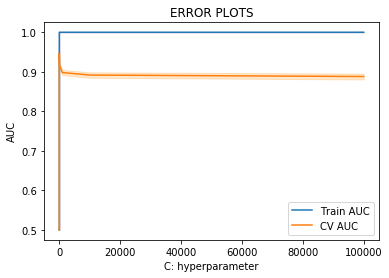

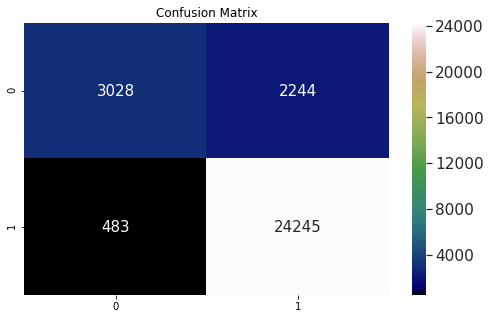

In [56]:
c_values = [10**-5,10**-4, 10**-3, 10**-2, 10**-1, 1, 10**1, 10**2, 10**3, 10**4,10**5]
clf, optimal_c, train_auc, train_auc_std, cv_auc, cv_auc_std = applying_logistic_regression('l1', False, c_values, train_vect, y_train)

optimal_c_bow1 = optimal_c

print('The optimal C is {}' .format(optimal_c))

train_cv_error_plot(train_auc, train_auc_std, cv_auc, cv_auc_std)

# log_reg_optimal = log_reg_optimal('l1', False, optimal_c)

log_reg_optimal = LogisticRegression(penalty='l1', dual=False, C=optimal_c)

retrain_log_reg(log_reg_optimal, train_vect, y_train, test_vect, y_test)

cm_fig(log_reg_optimal, y_test, test_vect)

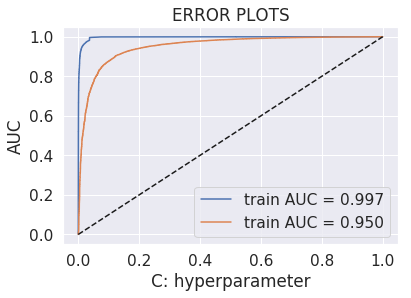

In [57]:
bow_auc1 = error_plot(log_reg_optimal, train_vect, y_train, test_vect, y_test)

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [58]:
sparsities_obtained = sparsity_of_matrix(log_reg_optimal, c_values, train_vect, y_train)
sparsities_obtained

,% sparsity,C(=1\lambda)
0,1.000000,0.00001
1,1.000000,0.00010
2,0.999238,0.00100
3,0.915389,0.01000
4,0.855959,0.10000
5,0.829885,1.00000
6,0.789380,10.00000
7,0.705611,100.00000
8,0.413859,1000.00000
9,0.093346,10000.00000


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

The optimal C is 0.01


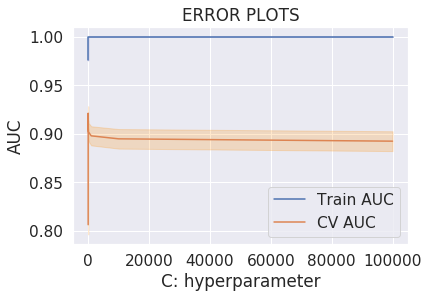

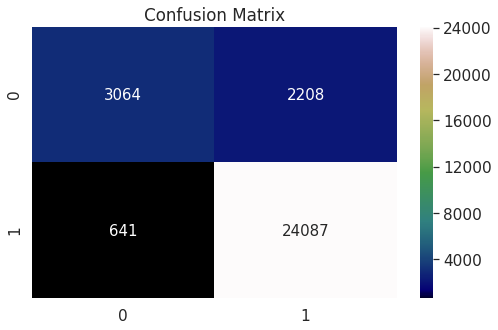

In [59]:
c_values = [10**-5,10**-4, 10**-3, 10**-2, 10**-1, 1, 10**1, 10**2, 10**3, 10**4,10**5]
clf, optimal_c, train_auc, train_auc_std, cv_auc, cv_auc_std = applying_logistic_regression('l2', True, c_values, train_vect, y_train)

optimal_c_bow2 = optimal_c

print('The optimal C is {}' .format(optimal_c))

train_cv_error_plot(train_auc, train_auc_std, cv_auc, cv_auc_std)

# log_reg_optimal = log_reg_optimal(optimal_c, 'l2', True)

log_reg_optimal = LogisticRegression(penalty='l2', dual=True, C=optimal_c)

retrain_log_reg(log_reg_optimal, train_vect, y_train, test_vect, y_test)

cm_fig(log_reg_optimal, y_test, test_vect)

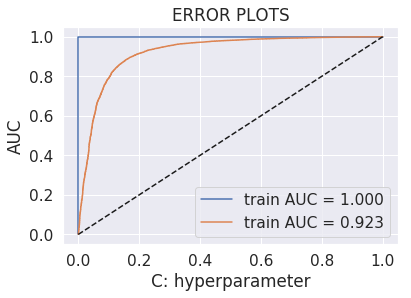

In [60]:
bow_auc2 = error_plot(log_reg_optimal, train_vect, y_train, test_vect, y_test)

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

(1, 99715)


No handles with labels found to put in legend.


threshold_pts:  [99715, 58, 37, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 0, 0, 0]
threshold_pts sum:  100305


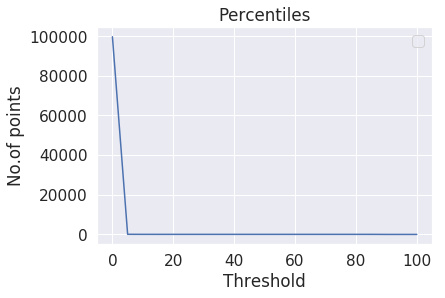

Multicollinear Features
couped
bitterwseet
administrated
cinni
andover


In [61]:
pertubation_test(log_reg_optimal, train_vect, y_train, 5, count_vect)

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [62]:
positive_features, negative_features = get_features_top(count_vect, log_reg_optimal)
positive_features

,features,probabilities
39813,great,0.598320
38494,good,0.393726
7351,best,0.386175
51694,love,0.307539
22904,delicious,0.286657
30521,excellent,0.258246
52256,loves,0.254890
64602,perfect,0.221305
58743,nice,0.215216
32390,favorite,0.211006


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [63]:
negative_features

,features,probabilities
25252,disappointing,-0.143327
95621,weak,-0.144449
95319,waste,-0.160981
66615,poor,-0.181563
82068,stale,-0.193654
43736,horrible,-0.196847
25149,disappointed,-0.200461
5088,awful,-0.201491
97517,worst,-0.210133
88238,terrible,-0.223112


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [64]:
X = np.array(final['Text_Summary'])
y = np.array(final['Score'])
data_split(X,y)
X_train = frompicklefile('X_train')
X_test = frompicklefile('X_test')
count_vect = apply_vectorizers_train_test('TF-IDF', X_train, X_test)

'train_vect' and 'test_vect' are the pickle files.


In [65]:
train_vect = frompicklefile('train_vect')
test_vect = frompicklefile('test_vect')
y_train = frompicklefile('y_train')
y_test = frompicklefile('y_test')

The optimal C is 0.01


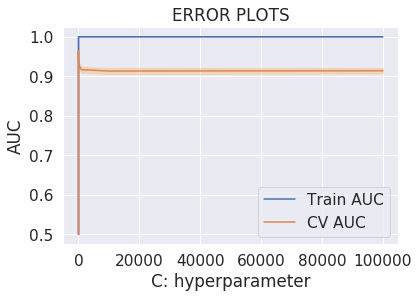

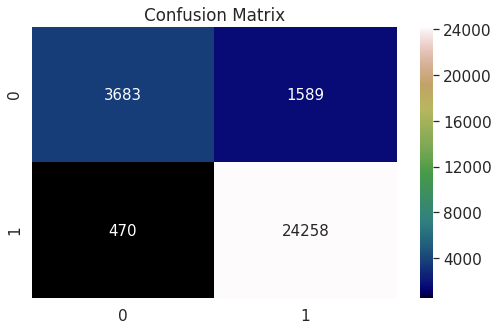

In [66]:
c_values = [10**-5,10**-4, 10**-3, 10**-2, 10**-1, 1, 10**1, 10**2, 10**3, 10**4,10**5]
clf, optimal_c, train_auc, train_auc_std, cv_auc, cv_auc_std = applying_logistic_regression('l1', False, c_values, train_vect, y_train)

optimal_c_tfidf1 = optimal_c

print('The optimal C is {}' .format(optimal_c))

train_cv_error_plot(train_auc, train_auc_std, cv_auc, cv_auc_std)

# log_reg_optimal = log_reg_optimal(optimal_c, 'l1', False)

log_reg_optimal = LogisticRegression(penalty='l1', dual=False, C=optimal_c)

retrain_log_reg(log_reg_optimal, train_vect, y_train, test_vect, y_test)

cm_fig(log_reg_optimal, y_test, test_vect)

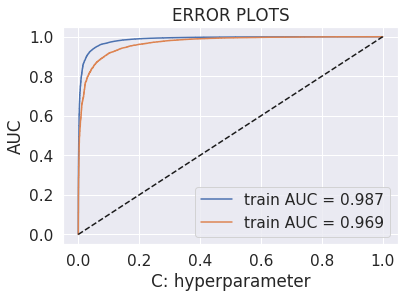

In [67]:
tfidf_auc1 = error_plot(log_reg_optimal, train_vect, y_train, test_vect, y_test)

#### [5.2.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [68]:
sparsities_obtained = sparsity_of_matrix(log_reg_optimal, c_values, train_vect, y_train)
sparsities_obtained

,% sparsity,C(=1\lambda)
0,1.000000,0.00001
1,1.000000,0.00010
2,0.997702,0.00100
3,0.909758,0.01000
4,0.715948,0.10000
5,0.667025,1.00000
6,0.559179,10.00000
7,0.186744,100.00000
8,0.025232,1000.00000
9,0.001711,10000.00000


### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

The optimal C is 0.0001


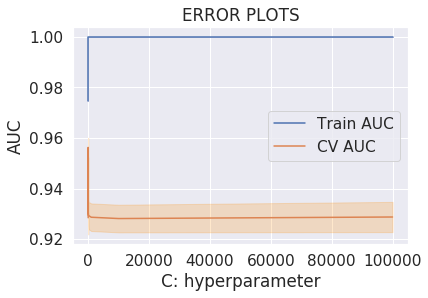

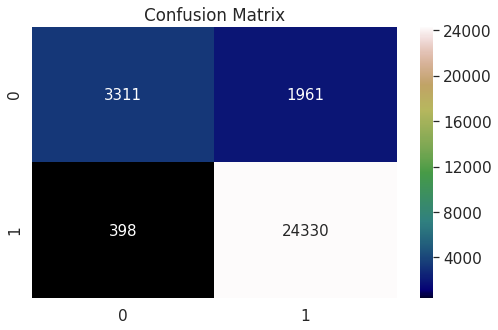

In [69]:
c_values = [10**-5,10**-4, 10**-3, 10**-2, 10**-1, 1, 10**1, 10**2, 10**3, 10**4,10**5]
clf, optimal_c, train_auc, train_auc_std, cv_auc, cv_auc_std = applying_logistic_regression('l2', True, c_values, train_vect, y_train)

optimal_c_tfidf2 = optimal_c

print('The optimal C is {}' .format(optimal_c))

train_cv_error_plot(train_auc, train_auc_std, cv_auc, cv_auc_std)

# log_reg_optimal = log_reg_optimal(optimal_c, 'l2', True)
log_reg_optimal = LogisticRegression(penalty='l2', dual=True, C=optimal_c)

retrain_log_reg(log_reg_optimal, train_vect, y_train, test_vect, y_test)

cm_fig(log_reg_optimal, y_test, test_vect)

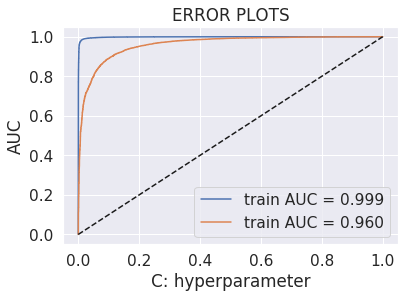

In [70]:
tfidf_auc2 = error_plot(log_reg_optimal, train_vect, y_train, test_vect, y_test)

#### [5.2.2.1] Performing pertubation test (multicollinearity check) on TF-IDF,<font color='red'> SET 2</font>

(1, 40901)


No handles with labels found to put in legend.


threshold_pts:  [40901, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
threshold_pts sum:  40901


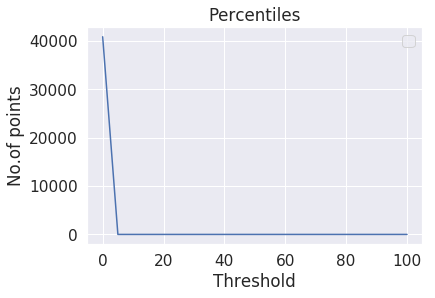

Multicollinear Features


In [71]:
pertubation_test(log_reg_optimal, train_vect, y_train, 5, count_vect)

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [72]:
positive_features, negative_features = get_features_top(count_vect, log_reg_optimal)
positive_features

,features,probabilities
15747,great,0.131751
15067,good,0.095569
2855,best,0.091720
20560,love,0.080356
8704,delicious,0.072581
11294,excellent,0.061406
20842,loves,0.059184
26873,perfect,0.056563
11887,favorite,0.053420
35562,tasty,0.052173


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [73]:
negative_features

,features,probabilities
33392,stale,-0.045962
17199,horrible,-0.048397
36167,terrible,-0.051259
2042,awful,-0.052400
24036,not buy,-0.052859
9287,disappointing,-0.053070
24774,not worth,-0.055712
24271,not good,-0.055888
24543,not recommend,-0.056152
40293,worst,-0.058863


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [74]:
X = np.array(final['Text_Summary'])
y = np.array(final['Score'])
data_split(X,y)
X_train = frompicklefile('X_train')
X_test = frompicklefile('X_test')
apply_vectorizers_train_test('AvgW2V', X_train, X_test)

100%|██████████| 30000/30000 [07:28<00:00, 66.91it/s] 


'train_vect' and 'test_vect' are the pickle files.


In [75]:
train_vect = frompicklefile('train_vect')
test_vect = frompicklefile('test_vect')
y_train = frompicklefile('y_train')
y_test = frompicklefile('y_test')

The optimal C is 10000


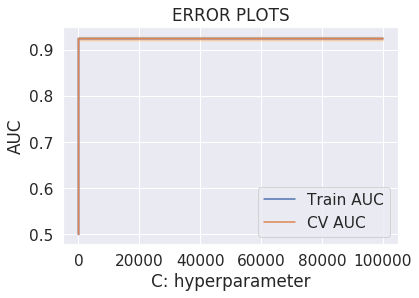

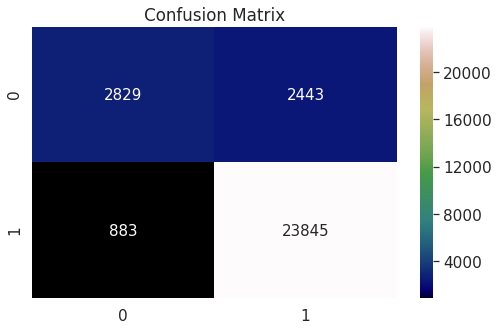

In [76]:
c_values = [10**-5,10**-4, 10**-3, 10**-2, 10**-1, 1, 10**1, 10**2, 10**3, 10**4,10**5]
clf, optimal_c, train_auc, train_auc_std, cv_auc, cv_auc_std = applying_logistic_regression('l1', False, c_values, train_vect, y_train)

optimal_c_avgw2v1 = optimal_c

print('The optimal C is {}' .format(optimal_c))

train_cv_error_plot(train_auc, train_auc_std, cv_auc, cv_auc_std)

# log_reg_optimal = log_reg_optimal(optimal_c, 'l1', False)
log_reg_optimal = LogisticRegression(penalty='l1', dual=False, C=optimal_c)

retrain_log_reg(log_reg_optimal, train_vect, y_train, test_vect, y_test)

cm_fig(log_reg_optimal, y_test, test_vect)

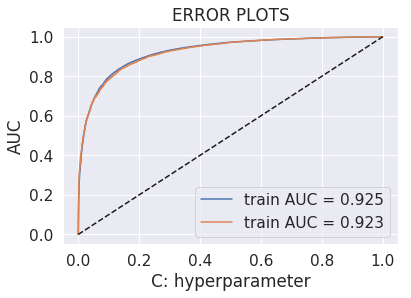

In [77]:
avgw2v_auc1 = error_plot(log_reg_optimal, train_vect, y_train, test_vect, y_test)

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

The optimal C is 0.1


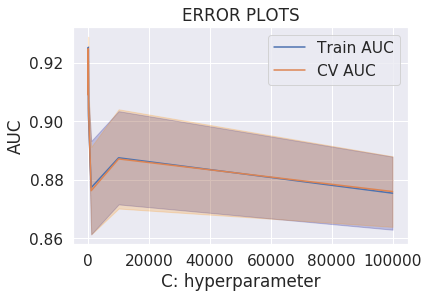

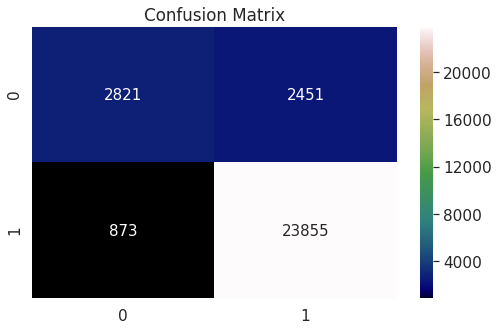

In [78]:
c_values = [10**-5,10**-4, 10**-3, 10**-2, 10**-1, 1, 10**1, 10**2, 10**3, 10**4,10**5]
clf, optimal_c, train_auc, train_auc_std, cv_auc, cv_auc_std = applying_logistic_regression('l2', True, c_values, train_vect, y_train)

optimal_c_avgw2v2 = optimal_c

print('The optimal C is {}' .format(optimal_c))

train_cv_error_plot(train_auc, train_auc_std, cv_auc, cv_auc_std)

# log_reg_optimal = log_reg_optimal(optimal_c, 'l2', True)
log_reg_optimal = LogisticRegression(penalty='l2', dual=True, C=optimal_c)

retrain_log_reg(log_reg_optimal, train_vect, y_train, test_vect, y_test)

cm_fig(log_reg_optimal, y_test, test_vect)

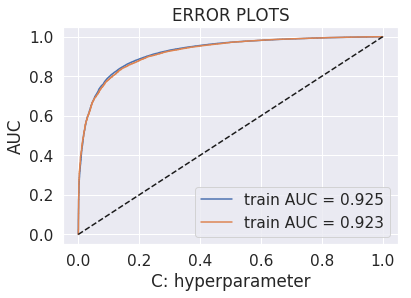

In [79]:
avgw2v_auc2 = error_plot(log_reg_optimal, train_vect, y_train, test_vect, y_test)

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [80]:
X = np.array(final['Text_Summary'])
y = np.array(final['Score'])
data_split(X,y)
X_train = frompicklefile('X_train')
X_test = frompicklefile('X_test')
apply_vectorizers_train_test('TF-IDF W2V', X_train, X_test)

100%|██████████| 30000/30000 [1:20:04<00:00,  7.54it/s]  


'train_vect' and 'test_vect' are the pickle files.


In [81]:
train_vect = frompicklefile('train_vect')
test_vect = frompicklefile('test_vect')
y_train = frompicklefile('y_train')
y_test = frompicklefile('y_test')

The optimal C is 0.1


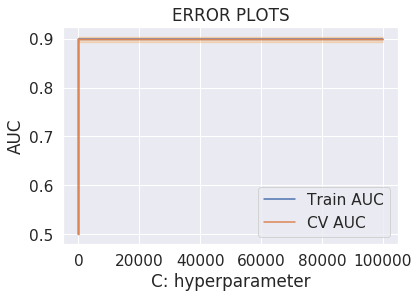

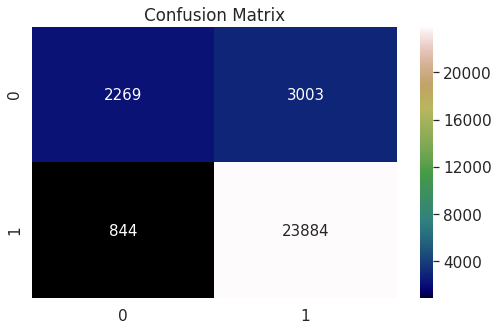

In [82]:
c_values = [10**-5,10**-4, 10**-3, 10**-2, 10**-1, 1, 10**1, 10**2, 10**3, 10**4,10**5]
clf, optimal_c, train_auc, train_auc_std, cv_auc, cv_auc_std = applying_logistic_regression('l1', False, c_values, train_vect, y_train)

optimal_c_tfidfw2v1 = optimal_c

print('The optimal C is {}' .format(optimal_c))

train_cv_error_plot(train_auc, train_auc_std, cv_auc, cv_auc_std)

# log_reg_optimal = log_reg_optimal(optimal_c, 'l1', False)
log_reg_optimal = LogisticRegression(penalty='l1', dual=False, C=optimal_c)


retrain_log_reg(log_reg_optimal, train_vect, y_train, test_vect, y_test)

cm_fig(log_reg_optimal, y_test, test_vect)

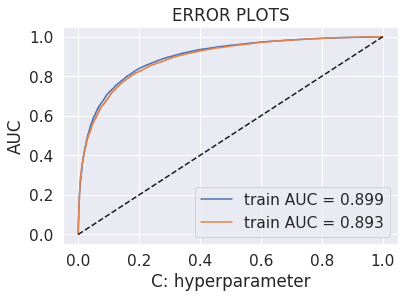

In [83]:
tfidfw2v_auc1 = error_plot(log_reg_optimal, train_vect, y_train, test_vect, y_test)

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [84]:
# Please write all the code with proper documentation

The optimal C is 0.01


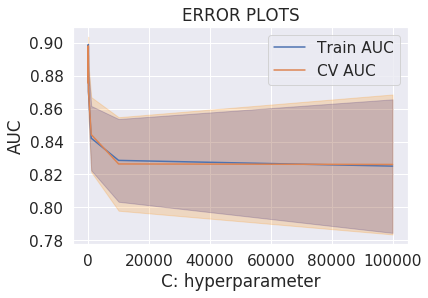

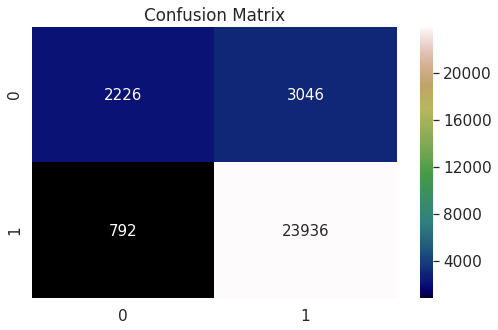

In [85]:
c_values = [10**-5,10**-4, 10**-3, 10**-2, 10**-1, 1, 10**1, 10**2, 10**3, 10**4,10**5]
clf, optimal_c, train_auc, train_auc_std, cv_auc, cv_auc_std = applying_logistic_regression('l2', True, c_values, train_vect, y_train)

optimal_c_tfidfw2v2 = optimal_c

print('The optimal C is {}' .format(optimal_c))

train_cv_error_plot(train_auc, train_auc_std, cv_auc, cv_auc_std)

# log_reg_optimal = log_reg_optimal(optimal_c, 'l2', True)
log_reg_optimal = LogisticRegression(penalty='l2', dual=True, C=optimal_c)


retrain_log_reg(log_reg_optimal, train_vect, y_train, test_vect, y_test)

cm_fig(log_reg_optimal, y_test, test_vect)

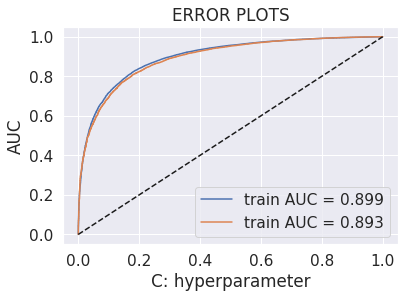

In [86]:
tfidfw2v_auc2 = error_plot(log_reg_optimal, train_vect, y_train, test_vect, y_test)

# [6] Conclusions

In [87]:
# Please compare all your models using Prettytable library

In [89]:
from prettytable import PrettyTable
    
model_metric = PrettyTable()

model_metric = PrettyTable(["Model Name", "Regularization", 'Hyperparameter', 'AUC'])

model_metric.add_row(["Bag of Words","L1", optimal_c_bow1, bow_auc1])
model_metric.add_row(["TF-IDF","L1", optimal_c_tfidf1, tfidf_auc1])
model_metric.add_row(["Avg W2V","L1", optimal_c_avgw2v1, avgw2v_auc1])
model_metric.add_row(["TF-IDF W2V","L1", optimal_c_tfidfw2v1, tfidfw2v_auc1])
model_metric.add_row(["Bag of Words","L2", optimal_c_bow2, bow_auc2])
model_metric.add_row(["TF-IDF","L2", optimal_c_tfidf2, tfidf_auc2])
model_metric.add_row(["Avg W2V","L2", optimal_c_avgw2v2, avgw2v_auc1])
model_metric.add_row(["TF-IDF W2V","L2", optimal_c_tfidfw2v2, tfidfw2v_auc2])


print(model_metric.get_string(start=0, end=8))

+--------------+----------------+----------------+--------------------+
|  Model Name  | Regularization | Hyperparameter |        AUC         |
+--------------+----------------+----------------+--------------------+
| Bag of Words |       L1       |      0.01      | 0.9503483292762435 |
|    TF-IDF    |       L1       |      0.01      |  0.9685668541102   |
|   Avg W2V    |       L1       |     10000      | 0.9229759004064372 |
|  TF-IDF W2V  |       L1       |      0.1       | 0.8930796427805233 |
| Bag of Words |       L2       |      0.01      | 0.9232448508666553 |
|    TF-IDF    |       L2       |     0.0001     | 0.9603429700574726 |
|   Avg W2V    |       L2       |      0.1       | 0.9229759004064372 |
|  TF-IDF W2V  |       L2       |      0.01      | 0.8928885040101249 |
+--------------+----------------+----------------+--------------------+


## [6.2] Observations:

1. The Run-Time for the Logistic Regression is very less and the results obtained are pretty good.

2. L1 regularization for both BOW and TF-IDF created sparsities in the Weight Vectors. The sparsity for weight vector decreased as the C value is increased.

3. For L2 regularization, BOW vectorizer had few multicollinear features and there were none by TF-IDF.

4. The Train and Test AUC scores of all the models are very close and even over lapping in the case of Avg W2V and
TF-IDF W2V
